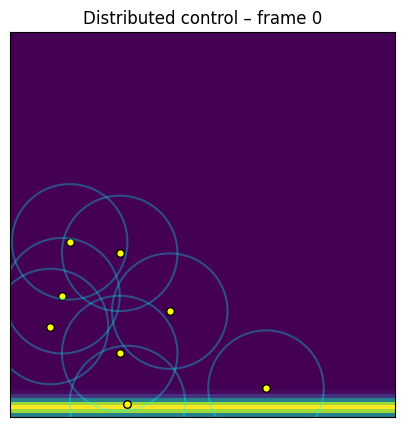

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML


# ---------- parameters ----------
grid_size = 100
num_agents = 8             # 1/4 of previous
steps = 180                 # frames
sigma = 10.0                 # vertical spread of the ridge
slope = 0.7                 # steepness of the inverse‑V arms
col_center = (grid_size - 1) / 2
R = 15                      # communication radius
eps_def = 1e-9          # tiny epsilon to avoid divide-by-zero
# ---------- repulsion parameters ----------
rep_R       = 8      # repulsion radius (in bins)
rep_strength = 5.0   # how strongly you push away



USE_INVERSE_V_DENSITY = False            # ← flip this at will, or toggle mid-run
USE_CIRCLE_DENSITY = False         # ← flip this at will, or toggle mid-run

# ---------- helper: desired inverse‑V density at a given apex row ----------
def inverse_v_density(apex_row):
    """Return a grid_size×grid_size array whose ridge forms an inverse‑V
    with apex at (apex_row, col_center)."""
    rows = np.arange(grid_size)
    cols = np.arange(grid_size)
    R, C = np.meshgrid(rows, cols, indexing='ij')
    row_peak = apex_row - slope * np.abs(C - col_center)   # ridge equation
    dist = R - row_peak
    density = np.exp(-dist ** 2 / (2 * sigma ** 2))
    density[density < 1e-6] = 0     # tiny cut‑off
    density /= density.sum()
    return density

def horizontal_band_density(row_centre, width=5.5):
    """
    Returns a grid_size×grid_size array whose high-probability region
    is a horizontal stripe centred at `row_centre` (float), with Gaussian
    fall-off in the vertical direction and uniform weight along columns.
    """
    rows = np.arange(grid_size)
    band = np.exp(-(rows - row_centre) ** 2 / (2 * width ** 2))
    density = np.repeat(band[:, None], grid_size, axis=1)   # tile across columns
    density /= density.sum()
    return density

def circle_density(row_centre, col_centre, radius=R):
    """
    Returns a grid_size×grid_size array whose high-probability region
    is roughly uniform inside a circle of radius `radius` around
    (row_centre, col_centre), with a light Gaussian fall-off beyond.
    """
    rows = np.arange(grid_size)
    cols = np.arange(grid_size)
    RR, CC = np.meshgrid(rows, cols, indexing='ij')
    
    dist = np.sqrt((RR - row_centre) ** 2 + (CC - col_centre) ** 2)
    
    # 1) uniform weight inside R
    density = np.zeros_like(dist)
    inside = dist <= radius
    density[inside] = 1.0     
    
    # 2) Gaussian tail outside R
    outside = ~inside
    density[outside] = np.exp(- ((dist[outside] - radius) ** 2) 
                              / (2 * sigma**2))
    
    # 3) normalize
    density /= density.sum()
    return density



# initial desired density (apex low)
p_star = inverse_v_density(apex_row=2)

# ---------- initial agent positions (ONLY lower half) ----------
rows = np.random.randint(0, grid_size // 2, size=num_agents)   # 0 … 9  (if grid_size = 20)
cols = np.random.randint(0, grid_size,        size=num_agents) # 0 … 19
agent_pos = np.vstack([rows, cols]).T                          # shape (num_agents, 2)

moves = np.array([[0, 0], [-1, 0], [1, 0], [0, 1], [0, -1]])

def in_bounds(pos):
    return (pos[:, 0] >= 0) & (pos[:, 0] < grid_size) & (pos[:, 1] >= 0) & (pos[:, 1] < grid_size)

# ---------- matplotlib setup ----------
fig, ax = plt.subplots(figsize=(5, 5))
img = ax.imshow(p_star, origin='lower', interpolation='nearest', vmin=0, vmax=p_star.max())
scat = ax.scatter(agent_pos[:, 1], agent_pos[:, 0], s=30, c='yellow', edgecolor='k')
ax.set_xlim(-0.5, grid_size - 0.5)
ax.set_ylim(-0.5, grid_size - 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Distrubuted control – frame 0")

# Create dynamic circle patches
circle_patches = []
for _ in range(num_agents):
    circ = plt.Circle((0,0), R, edgecolor='cyan', fill=False, alpha=0.3, linewidth=1.5)
    ax.add_patch(circ)
    circle_patches.append(circ)



# ---------- update per frame ----------
def update(frame):
    global agent_pos, p_star
    # --- move target upward ---
    apex_row  = 2 + frame * (grid_size - 4 - 2) / (steps - 1)
    if USE_INVERSE_V_DENSITY:
        p_star    = inverse_v_density(apex_row)
    elif USE_CIRCLE_DENSITY:
        p_star    = circle_density(apex_row, col_center, radius=5.5)
    else:
        p_star    = horizontal_band_density(apex_row, width=1.5)
    flat_p_star = p_star.flatten()

    # empirical density
    counts = np.zeros((grid_size, grid_size), dtype=int)
    for r, c in agent_pos:
        counts[r, c] += 1
    p_hat = counts / num_agents
    flat_p_hat = p_hat.flatten()


    # ---------------------- helper: neighbourhood mask ------------------------
    row_idx = np.arange(grid_size)
    col_idx = np.arange(grid_size)
    RR, CC  = np.meshgrid(row_idx, col_idx, indexing='ij')

    def neighbourhood_mask(center_r, center_c, radius=R):
        """Boolean mask of bins within Chebyshev distance ≤ radius."""
        return (np.abs(RR - center_r) <= radius) & (np.abs(CC - center_c) <= radius)

    # ---------------------- inside update(frame) ------------------------------
    # (everything until counts / p_hat stays as in your current code)

    # move agents (centroid-of-deficit rule)
    new_pos = agent_pos.copy()
    for idx, (r, c) in enumerate(agent_pos):
        mask   = neighbourhood_mask(r, c, R)
        deficit_mat = np.maximum(p_star - p_hat, 0.0) * mask          # (φ−c)^+
        total_def   = deficit_mat.sum()
        if total_def < eps_def:
            # nothing to fix in my neighbourhood → stay put
            continue
        # centroid (weighted by deficit)
        g_r = (deficit_mat * RR).sum() / total_def
        g_c = (deficit_mat * CC).sum() / total_def

        # compute repulsion vector from other agents
        rep_y, rep_x = 0.0, 0.0
        for (orow, ocol) in agent_pos:
            dy = r - orow
            dx = c - ocol
            dist2 = dx*dx + dy*dy
            if 0 < dist2 <= rep_R**2:
                # inverse‐square fall‐off
                rep_y +=  dy / (dist2 + 1e-3)
                rep_x +=  dx / (dist2 + 1e-3)

        # combine attraction (to deficit centroid) and repulsion
        vx = (g_c - c) + rep_strength * rep_x
        vy = (g_r - r) + rep_strength * rep_y

        # pick a one‐cell move in that direction
        dr = int(np.sign(vy))
        dc = int(np.sign(vx))
        cand = np.array([r + dr, c + dc])

        # keep inside bounds
        if in_bounds(cand.reshape(1, 2))[0]:
            new_pos[idx] = cand

    agent_pos = new_pos


    img.set_data(p_star)
    scat.set_offsets(np.c_[agent_pos[:, 1], agent_pos[:, 0]])
    ax.set_title(f"Distributed control – frame {frame}")

    # Update circle positions so they follow the agents
    for circ, (r, c) in zip(circle_patches, agent_pos):
        circ.center = (c, r)

    # Return *all* artists that have changed
    return [img, scat] + circle_patches

anim = FuncAnimation(fig, update, frames=steps, interval=120, blit=True)


In [51]:
HTML(anim.to_jshtml())          # renders the animation right in the notebook